# Solution to HW 1

In [1]:
## Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Problem 1: Measure IIP 3 of Saleh device with Two-Tone Method

First, we need the definition of the Saleh device. We will use this model with parameters $\alpha=10$ and $\beta=0.1$. From the class notes, we know that the 1dB compression point is
$$
    P_{in,1\text{dB}} = x^2_{1 \text{dB}} = \frac{1-v_{1 \text{dB}}}{v_{1 \text{dB}} \cdot \beta}
$$
with $v_{1 \text{dB}}=10^{-1/20}$. With $\beta=0.1$, $P_{in,1\text{dB}}$ is computed below.

In [3]:
# model parameters
alpha = 10
beta = 0.1

# compute 1dB compression point
v_1dB = 10**(-1/20)
P_1dB = (1 - v_1dB)/(v_1dB * beta)

print("The 1dB compression point is {:4.2f} ({:4.2f} dB)".format(P_1dB, 10*np.log10(P_1dB)))

The 1dB compression point is 1.22 (0.86 dB)


In [4]:
def Saleh(x, alpha=2, beta=1):
    """Saleh model for a non-linear amplifier
    
    Inputs:
    x - input voltage
    alpha - small signal gain (default: 2)
    beta - saturation parameter (default: 1)

    Returns:
    output voltage
    """

    return alpha * x / (1 + beta * x**2)

**Exercise: Measuring IIP3** IIP3 is difficult to measure with just a single tone. In order to drive $A(f_c)$ to zero, the device has to operate deep in the nonlinear region where the third-order approximation is no longer valid. As an alternative, the following procedure is used in practice to measure IIP3.

*Step 1: Measure the linear gain* For a single tone at frequency $f_1$ the input power $P_{in}$ is varied over a range well below the 1dB compression point and the corresponding output powers $P_{out}$ are measured. For small input powers, we have
$$
    P_{out} = a_1^2 \cdot P_{in},
$$
where $a_1$ is the linear term from the third order approximation.
When output power is plotted over input power on a double logarithmic scale (e.g., both axes in dB), the measurements should form a straight line with slope 1. Why?

**Answer:** We saw that the 1dB compression point is right around 0dB. Hence we will vary the input power from -20dB to -10dB for this measurement.

Moreover, to be able to measure the power at a given frequency - this will become more relevant in step 2 - we pick an integration period $T$ and frequencies $f_1$ and $f_2$ such that $f_1T$ and $f_2T$ are integers. We choose an arbitrary sampling rate of 100MHz. 

In [22]:
## Measurement parameters 
fs = 100e6
N = 1024
T = N/fs # measurement period

# ensure f_i*T are integers; also want 2*f2-f1 and 2*f1-f2 to be positive
f1 = 5/T
f2 = 7/T

# base signal of frequency f1, the power of this signal will be scaled below
s1 = np.sqrt(2)*np.cos(2*np.pi*f1*np.arange(N)*T/N)

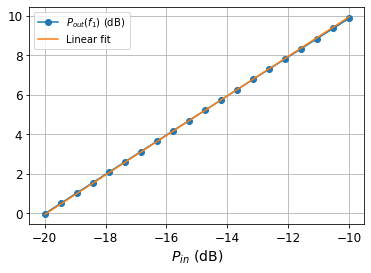

In [26]:
## Measure output power for given input power
P_in_min_dB = -20
P_in_max_dB = -10
M = 20
P_in = np.logspace(P_in_min_dB/10, P_in_max_dB/10, M)
P_out = np.zeros_like(P_in)

for m in range(M):
    s_in = np.sqrt(P_in[m]) * s1
    s_out = Saleh(s_in, alpha, beta)

    P_out[m] = (1/N * np.sum(s_out *s1))**2

P_in_dB = 10*np.log10(P_in)
P_out_dB = 10*np.log10(P_out)

# linear fit with slope 1
b1 = np.mean(P_out_dB - P_in_dB)
P_fit_dB = P_in_dB + b1

## plot
plt.plot(P_in_dB, P_out_dB, '-o', label=r'$P_{out}(f_1)$ (dB)')
plt.plot(P_in_dB, P_fit_dB, label=r'Linear fit')
plt.grid()
plt.legend()
plt.xlabel('$P_{in}$ (dB)')

plt.show()

*Step 2: Two-tone measurements* A second tone of frequency $f_2$ and the same power $P_{in}$ is added; i.e., the test signal is
$$
    \sqrt{2P_{in}} (\cos(2\pi f_1 t) + \cos(2\pi f_2 t)).
$$
When this signals is passed through a third-order non-linearity $y(x) = a_1 x - a_3 x^3$, then there will be signal components at the frequencies $2f_1-f_2$ and $2f_2-f_1$. Show that the amplitude of these components equals
$$
    A(2f_2-f_1) = \sqrt{2P_{in}} \cdot (\frac{3 a_3}{2}P_{in}).
$$
Note that this term appears in the expression for the single-tone amplitude $A(f_c)$. The corresponding output power is
$$
    P_{out}(2f_2-f_1) = \frac{(A(2f_2-f_1))^2}{2}.
$$
When this output power is plotted over the input power on a double logarithmic scale, then measurements should form a straight line wth slope 3. Why?

**Answer** The term at frequency $2f_2-f_1$ results from $3 a_3  \cdot (\sqrt{2P_{in}} (\cos(2\pi f_1 t))^2 \cdot \sqrt{2P_{in}} (\cos(2\pi f_2 t)$ in the expansion of $a_3 \cdot (\sqrt{2P_{in}} (\cos(2\pi f_1 t) + \cos(2\pi f_2 t)))^3$.

We can proceed as above with the input signal $\sqrt{2P_{in}} (\cos(2\pi f_1 t) + \cos(2\pi f_2 t))$ and measure power at frequency $2f_2-f_1$.

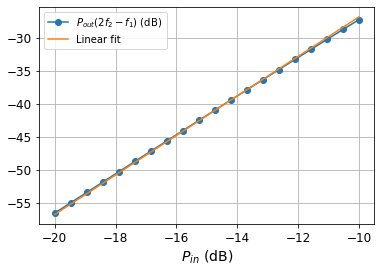

In [27]:
# base signal of frequency f2, the power of this signal will be scaled below
s2 = np.sqrt(2)*np.cos(2*np.pi*f2*np.arange(N)*T/N)
# signal at frequency 2*f2-f1
s21 = np.sqrt(2)*np.cos(2*np.pi*(2*f2-f1)*np.arange(N)*T/N)

P_out21 = np.zeros_like(P_in)

for m in range(M):
    s_in = np.sqrt(P_in[m]) * (s1 + s2)
    s_out = Saleh(s_in, alpha, beta)

    P_out21[m] = (1/N * np.sum(s_out *s21))**2 # measure power at 2f2-f1

P_in_dB = 10*np.log10(P_in)
P_out21_dB = 10*np.log10(P_out21)

# linear fit with slope 3
b3 = np.mean(P_out21_dB - 3*P_in_dB)
P_fit21_dB = 3*P_in_dB + b3

## plot
plt.plot(P_in_dB, P_out21_dB, '-o', label=r'$P_{out}(2f_2-f_1)$ (dB)')
plt.plot(P_in_dB, P_fit21_dB, label=r'Linear fit')
plt.grid()
plt.legend()
plt.xlabel('$P_{in}$ (dB)')

plt.show()

*Step 3: Extrapolate to find Intercept* When measurements are performed well below the 1dB compression point, the two lines will not intersect. However, when the two straight line segments are extended, i.e., extrapolated to higher power, we can find the input power where the two lines intersect. This point of intersection is the third-order intercept point (IP3). The x-coordinate is IIP3 and the y-coordinate is OIP3.

With the fits computed above, we can easily find the point of intersection. The x-cordinate of the intersection is the IIP3 and is the solution of
$$
\text{IIP}_3 + b_1 = 3 \text{IIP}_3 + b_3 \Rightarrow \text{IIP}_3 = \frac{b_1-b_3}{2} 
$$
and the corresponding OIP3 is $\text{OIP}_3 = \frac{3b_1-b_3}{2}$.

We compute these values and plot the extended fit lines below.

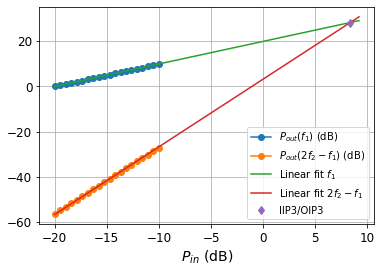

IIP3 = 8.36 dB, OIP3 = 28.30 dB


In [30]:
## Compute IIP3 and OIP3
IIP3 = (b1 - b3)/2
OIP3 = (3*b1 - b3)/2

P_in_fit = np.logspace(P_in_min_dB/10, 1.1*IIP3/10, 50)
P_in_fit_dB = 10*np.log10(P_in_fit)

plt.plot(P_in_dB, P_out_dB, '-o', label=r'$P_{out}(f_1)$ (dB)')
plt.plot(P_in_dB, P_out21_dB, '-o', label=r'$P_{out}(2f_2-f_1)$ (dB)')
plt.plot(P_in_fit_dB , P_in_fit_dB + b1, label='Linear fit $f_1$')
plt.plot(P_in_fit_dB , 3*P_in_fit_dB + b3, label='Linear fit $2f_2-f_1$')
plt.plot(IIP3, OIP3, 'd', label="IIP3/OIP3")
plt.grid()

plt.legend()
plt.xlabel('$P_{in}$ (dB)')

plt.show()

print("IIP3 = {:4.2f} dB, OIP3 = {:4.2f} dB".format(IIP3, OIP3))

## Problem 2: Pre-distortion

**Exercise: Pre-Distortion** Derive a pre-distortion function $y=f_{PD}(x)$ for the Saleh nonlinearity $f_S(x)$. This predistortion function must be such that 
$$
    f_S(f_{PD}(x)) = \alpha x.
$$

Verify that your pre-distortion works by computing and plotting the power spectral density of the output signal. It should show no harmonic distortions.

**Answer:** From the problem statement, it follows immediately that the pre-distortion function must satisfy
$$
    f_{PD}(x) = f_S^{-1}(\alpha x),
$$
i.e., we must find the inverse function to the Saleh non-linearity.

The Saleh non-linearity is given by
$$
    y = \frac{\alpha x}{1 + \beta x^2}
$$
where $x$ and $y$ are the input and output voltages, respectively, and $\alpha$ and $\beta$ are model parameters.

The output voltage is maximal when the input voltage equals $x_s = \frac{1}{\sqrt{\beta}}$. The corresponding output voltage is called the saturation voltage and is given by $A_s=\frac{\alpha}{2\sqrt{\beta}}$.
We can only invert the non-linearity up to the saturation volatage!

The inverse of the Saleh non-linearity and, thus, the pre-distortion function is given by
$$
    y = \frac{1 - \sqrt{1-4\beta x^2}}{2\beta x}
$$
for $|x| \leq \frac{1}{2\sqrt{\beta}}$. For, $|x| = \frac{1}{2\sqrt{\beta}}$, the pre-distortion function produces $\frac{1}{\sqrt{\beta}}$ so that the resulting output voltage from the amplifier is the saturation voltage. For larger values of $x$, linearization is not possible. When that occurs, it is best to output $\frac{1}{\sqrt{\beta}}$. The function below does that

In [61]:
def _f_PD(x, alpha, beta):
    """Predistortion for Saleh model

    This function works on scalars. See function f_PD below for a function that 
    boths scalars and arrays.
    
    Inputs:
    x - scalar input voltage
    alpha - linear term in Saleh model
    beta - saturation term in Saleh model

    Returns:
    pre-distorted voltage value
    """
    ## prevent divide by (near) zero
    # For very small inputs, no distortion occurs
    if np.abs(x) < 1e-10:
        return x

    ## Is input too large to be corrected
    if beta * x**2 > 0.25:
        return np.sign(x) * 1/np.sqrt(beta)

    ## correction is possible
    return (1 - np.sqrt(1 - 4 * beta * x**2)) / (2 * beta * x)


In [62]:
def f_PD(x, alpha, beta):
    """Wrapper function for _f_PD
    
    This function accepts both scalars and arrays; it delagates work to the function _f_PD 
    """
    try:
        N = len(x)  # this fails with TypeError if x is a scalar
        y = np.empty_like(x)
        for n in range(N):
            y[n] = _f_PD(x[n], alpha, beta)

        return y
    except TypeError:
        return _f_PD(x, alpha, beta)

In [65]:
# input amplitudes
x = np.linspace(0, 3, 101) # input amplitude

# model parameters
alpha = 10
beta = 0.1

# compute outputs for Saleh model, ideal amp, and third-order approximation
y = Saleh(x, alpha, beta)
yi = 1*alpha * x
yp = Saleh(f_PD(x, alpha, beta), alpha, beta)

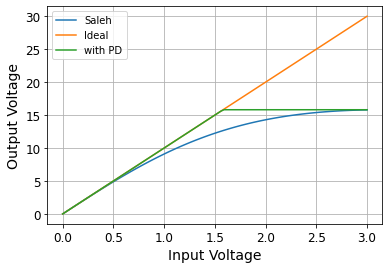

In [66]:
# plots
plt.plot(x, y, x, yi, x, yp)
#plt.plot(x, yp)
plt.grid()

plt.xlabel('Input Voltage')
plt.ylabel('Output Voltage')

plt.legend(['Saleh', 'Ideal', 'with PD'])

plt.show()

With pre-distortion, gain curve is exactly linear until saturation.

Next we pass a signal containing multiple tones through the Saleh non-linearity - with and without predistortion. The goal is to verify that pre-distortion removes all harmonic and intermodulation products.

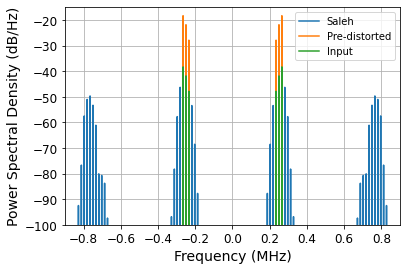

In [81]:
## Generate the baseband signal
fs = 2e6
W = fs/64
N = 2048

# frequency axis
ff = (np.arange(N) - N//2)*fs/N

#time axis and signal
tt = np.arange(N)/fs
x = 1/np.sqrt(14) * (np.exp(-1j*2*np.pi*W/2*tt) + 2 + 3*np.exp(1j*2*np.pi*W/2*tt))

# set the carrier frequency and generate the passband signal
# need to tweak the amplitude a little bit to prevent saturation
fc = fs/8
xp = 0.95*np.real(x * np.exp(2j*np.pi*fc*tt))

# now compute the PSD
Xp = np.fft.fftshift(np.fft.fft(xp))/np.sqrt(N)
PSD_p = np.abs(Xp)**2 / fs

# pass ignal through the non-linear amplifier model 
yp = Saleh(xp, alpha, beta) # (without pre-distortion)
zp = Saleh(f_PD(xp, alpha, beta), alpha, beta) # (with pre-distortion)

# then compute the PSD
Yp = np.fft.fftshift(np.fft.fft(yp))/np.sqrt(N)
PSD_yp = np.abs(Yp)**2 / fs

Zp = np.fft.fftshift(np.fft.fft(zp))/np.sqrt(N)
PSD_zp = np.abs(Zp)**2 / fs


# and plot
plt.plot(ff/1e6, 10*np.log10(PSD_yp), label="Saleh")
plt.plot(ff/1e6, 10*np.log10(PSD_zp), label="Pre-distorted")
plt.plot(ff/1e6, 10*np.log10(PSD_p), label="Input")
plt.grid()

plt.ylim([-100,-15])
plt.xlim([-0.9, 0.9])

plt.xlabel('Frequency (MHz)')
plt.ylabel('Power Spectral Density (dB/Hz)')

plt.legend()

plt.show()

With pre-distortion, harmonic and intermodulation products are gone!